In [10]:
#######################################################################
## IMPORTS ##
#######################################################################

import numpy as np
from numpy import linalg as nplinalg
from scipy import linalg as splinalg
import pandas as pd
import time
import matplotlib.pyplot as plt
from random import sample
import tracemalloc
from matplotlib import colors
import string
import copy
from itertools import product
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

#######################################################################
## WALSH-HADAMARD MATRIX MULTIALLELIC EXTENSION FUNCTIONS ##
#######################################################################

def H_matrix_recursive(
    sequence_length = 1,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the Walsh-Hadamard (WH) transform using recursive definition.

    :param sequence_length: sequence length (default:1).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :returns: WH matrix as Numpy array.
    """
    mat = np.asarray([[1]])
    for i in range(sequence_length):
        mat_list = []
        for j in range(num_states):
            if j==0:
                mat_list += [np.concatenate([mat]*num_states, axis = 1)]
            else:
                if invert:
                    mat_list += [[mat]*num_states]
                    mat_list[-1][j] = mat_list[-1][j]*(1-num_states)
                else:
                    mat_list += [[mat*0]*num_states]
                    mat_list[-1][0] = mat
                    mat_list[-1][j] = -mat
                mat_list[-1] = np.concatenate(mat_list[-1], axis = 1)
        mat = np.concatenate(mat_list, axis = 0)
        if invert:
            mat = (1/num_states)*mat
    return mat

def H_matrix(
    str_geno,
    str_coef,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the Walsh-Hadamard (WH) transform using the formula to get elements.

    :param str_geno: list of genotype strings where '0' indicates WT state.
    :param str_coef: list of coefficient strings where '0' indicates WT state.
    :param num_states: integer number of states (identical per position) or list of integers with length matching that of sequences.
    :param invert: invert the matrix.
    :returns: WH matrix as Numpy array.
    """
    #Genotype string length
    string_length = len(str_geno[0])
    #Number of states per position in genotype string (float)
    if type(num_states) == int:
        num_states = [float(num_states) for i in range(string_length)]
    else:
        num_states = [float(i) for i in num_states]
    #Convert reference characters to "." and binary encode
    str_coef = [[ord(j) for j in i.replace("0", ".")] for i in str_coef]
    str_geno = [[ord(j) for j in i] for i in str_geno]
    #Matrix representations
    num_statesi = np.repeat([num_states], len(str_geno)*len(str_coef), axis = 0)
    str_genobi = np.repeat(str_geno, len(str_coef), axis = 0)
    str_coefbi = np.transpose(np.tile(np.transpose(np.asarray(str_coef)), len(str_geno)))
    str_genobi_eq_str_coefbi = (str_genobi == str_coefbi)
    #Factors
    row_factor2 = str_genobi_eq_str_coefbi.sum(axis = 1)
    if invert:
        row_factor1 = np.prod(str_genobi_eq_str_coefbi * (num_statesi-2) + 1, axis = 1)       
        return ((row_factor1 * np.power(-1, row_factor2))/np.prod(num_states)).reshape((len(str_geno),-1))
#         row_factor1 = np.prod(np.power(1-num_statesi, str_genobi_eq_str_coefbi), axis = 1)       
#         return (row_factor1/np.prod(num_states)).reshape((len(str_geno),-1))
    else:
        row_factor1 = (np.logical_or(np.logical_or(str_genobi_eq_str_coefbi, str_genobi==ord('0')), str_coefbi==ord('.')).sum(axis = 1) == string_length).astype(float)            
        return ((row_factor1 * np.power(-1, row_factor2))).reshape((len(str_geno),-1))

def V_matrix(
    str_coef,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the diagonal weighting matrix using the formula to get elements.

    :param str_geno: list of genotype strings where '0' indicates WT state.
    :param str_coef: list of coefficient strings where '0' indicates WT state.
    :param num_states: integer number of states (identical per position) or list of integers with length matching that of sequences (default:2).
    :param invert: invert the matrix (default:False).
    :returns: diagonal weighting matrix as a numpy matrix.
    """

    #Genotype subset
    str_geno = str_coef
    #Genotype string length
    string_length = len(str_geno[0])
    #Number of states per position in genotype string
    if type(num_states) == int:
        num_states = [float(num_states) for i in range(string_length)]
    else:
        num_states = [float(i) for i in num_states]
    #Convert reference characters to "."
    str_coef_ = [i.replace("0", ".") for i in str_coef]
    #initialize V matrix
    V = np.array([[0.0]*len(str_coef)]*len(str_geno))
    #Fill matrix
    for i in range(len(str_geno)):
        factor1 = int(np.prod([c for a,b,c in zip(str_coef_[i], str_geno[i], num_states) if ord(a) != ord(b)]))
        factor2 = sum([1 for a,b in zip(str_coef_[i], str_geno[i]) if ord(a) == ord(b)])
        if invert:
            V[i,i] = factor1 * np.power(-1, factor2)
        else:
            V[i,i] = 1/(factor1 * np.power(-1, factor2))
    return V

def H_matrix_recursive_resources(
    l_start = 1,
    l_end = 10,
    num_states = 2,
    invert = False,
    invert_numerically = False,
    n_iterations = 10,
    invert_lib = 'numpy'):
    """
    Execution time and memory to construct multiallelic extension of the Walsh-Hadamard (WH) transform using recursive definition.

    :param l_start: start sequence length (default:1).
    :param l_end: end sequence length (default:10).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param invert_numerically: invert the matrix numerically (default:False).
    :param n_iterations: number of iterations for averaging (default:10).
    :param invert_lib: library to use for matrix inversion (default:numpy).
    :returns: dictionary of pandas DataFrames with resource usage.
    """
    time_list = []
    mem_list = []
    l_range = range(l_start, l_end+1, 1)
    for j in range(n_iterations):
        for i in range(len(l_range)):
            if len(time_list)<len(l_range):
                time_list += [[]]
                mem_list += [[]]
            #record start time and memory
            tracemalloc.start()
            start = time.time()
            if invert:
                if invert_numerically:
                    if invert_lib == 'numpy':
                        nplinalg.inv(H_matrix_recursive(l_range[i], num_states))
                    if invert_lib == 'scipy':
                        splinalg.inv(H_matrix_recursive(l_range[i], num_states))
                else:
                    H_matrix_recursive(l_range[i], num_states, invert = True)
            else:
                H_matrix_recursive(l_range[i], num_states)
            #record end time and memory
            end = time.time()
            mem = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time_list[i] += [end-start]
            mem_list[i] += [mem[1]-mem[0]]
    time_df = pd.DataFrame(time_list)
    time_df = pd.DataFrame({
        'mean' : list(time_df.mean(axis = 1)), 
        'std' : list(time_df.std(axis = 1))})
    mem_df = pd.DataFrame(mem_list)
    mem_df = pd.DataFrame({
        'mean' : list(mem_df.mean(axis = 1)), 
        'std' : list(mem_df.std(axis = 1))})
    return {'time': time_df, 'memory': mem_df}

def H_matrix_elements_resources(
    l_start = 1,
    l_end = 10,
    num_states = 2,
    invert = False,
    n_iterations = 10,
    n_elements = -1):
    """
    Execution time and memory to construct multiallelic extension of the Walsh-Hadamard (WH) transform using the formula to get elements.

    :param l_start: start sequence length (default:1).
    :param l_end: end sequence length (default:10).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param n_iterations: number of iterations for averaging (default:10).
    :param n_elements: number of random elements to obtain (default:all).
    :returns: dictionary of pandas DataFrames with resource usage.
    """
    alphabet = ['0']+list(string.ascii_lowercase)
    time_list = []
    mem_list = []
    l_range = range(l_start, l_end+1, 1)
    for j in range(n_iterations):
        for i in range(len(l_range)):
            if len(time_list)<len(l_range):
                time_list += [[]]            
                mem_list += [[]]
            #Number of elements to extract
            n_elements_i = n_elements
            if n_elements>(np.power(num_states, l_range[i])) or n_elements==-1:
                n_elements_i = np.power(num_states, l_range[i])
            #Genotypes/coefficients
            n_geno = np.power(num_states, l_range[i])
            geno_indices = sample(range(np.power(num_states, l_range[i])),n_elements_i)
            seqs = [''.join([str(gj) for gj in [alphabet[gk] for gk in numberToBase(gi, num_states)]]).zfill(l_range[i]) for gi in geno_indices]
            #record start time
            tracemalloc.start()
            start = time.time()
            H_matrix(
                str_geno = seqs,
                str_coef = seqs,
                num_states = num_states,
                invert = invert)
            #record end time and memory
            end = time.time()
            mem = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time_list[i] += [end-start]
            mem_list[i] += [mem[1]-mem[0]]
    time_df = pd.DataFrame(time_list)
    time_df = pd.DataFrame({
        'mean' : list(time_df.mean(axis = 1)), 
        'std' : list(time_df.std(axis = 1))})
    mem_df = pd.DataFrame(mem_list)
    mem_df = pd.DataFrame({
        'mean' : list(mem_df.mean(axis = 1)), 
        'std' : list(mem_df.std(axis = 1))})
    return {'time': time_df, 'memory': mem_df}

def plot_H_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot Walsh-Hadamard matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #All genotypes
    all_geno = genotypeLandscape(
        sequence_length = sequence_length,
        num_states = num_states)
    #H matrix
    hmat = H_matrix(
        str_geno = all_geno,
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    divnorm=colors.TwoSlopeNorm(vmin=np.min(hmat), vcenter=0., vmax=np.max(hmat))
    im = ax.pcolormesh(np.flip(hmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()

def plot_VH_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot VH matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #All genotypes
    all_geno = genotypeLandscape(
        sequence_length = sequence_length,
        num_states = num_states)
    #H matrix
    hmat = H_matrix(
        str_geno = all_geno,
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #V matrix
    vmat = V_matrix(
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #VH matrix
    if invert:
        vhmat = np.matmul(hmat, vmat)
    else:
        vhmat = np.matmul(vmat, hmat)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    divnorm=colors.TwoSlopeNorm(vmin=np.min(vhmat), vcenter=0., vmax=np.max(vhmat))
    im = ax.pcolormesh(np.flip(vhmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()

def G_matrix(
    sequence_length,
    num_states,
    invert = False):
    """
    Construct G matrix.

    :param sequence_length: integer sequence length.
    :param num_states: integer number of states per position.
    :param invert: invert the matrix (default:False).
    :returns: G matrix as a numpy matrix.
    """
    all_geno = genotypeLandscape(sequence_length, num_states)
    df = pd.DataFrame({str(len(all_geno[0])-i):[j[i] for j in all_geno] for i in range(len(all_geno[0]))})
    cat_cat = make_pipeline(
        OneHotEncoder(drop = np.array(['0']*sequence_length), sparse = False),
        PolynomialFeatures(degree=sequence_length, interaction_only=True, include_bias=True)
    )
    column_trans = ColumnTransformer(
        [('ab_cat', cat_cat, df.columns)],
         remainder='drop')
    x = pd.DataFrame(column_trans.fit_transform(df), columns = column_trans.get_feature_names_out())
    col_names = column_trans.get_feature_names_out()
    col_names.sort()
    gmat_inv = np.array(x[[i for i in col_names if sum(x[i])!=0]])
    if invert:
        return gmat_inv
    else:
        return splinalg.inv(gmat_inv)

def plot_G_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot G matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #H matrix
    gmat = G_matrix(
        sequence_length = sequence_length,
        num_states = num_states,
        invert = invert)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    if len(set([np.min(gmat), 0., np.max(gmat)]))==2:
        divnorm=colors.TwoSlopeNorm(vmin=-list(set([np.min(gmat), 0., np.max(gmat)]))[1], vcenter=0., vmax=np.max(gmat))
        im = ax.pcolormesh(np.flip(gmat, axis = 0), cmap="bwr", norm=divnorm)
    else:
        divnorm=colors.TwoSlopeNorm(vmin=np.min(gmat), vcenter=0., vmax=np.max(gmat))
        im = ax.pcolormesh(np.flip(gmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()

#######################################################################
## EXTRA FUNCTIONS ##
#######################################################################

def numberToBase(
    n, 
    b):
    """
    Convert number from base 10 to arbitrary base b.

    :param n: number in base 10.
    :param b: base.
    :returns: list representation of number in base b.
    """
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def genotypeLandscape(
    sequence_length,
    num_states):
    """
    Generate all possible sequences in genotype landscape.

    :param sequence_length: integer sequence length.
    :param num_states: integer number of states per position.
    :returns: list of string sequences.
    """
    alphabet = ['0']+list(string.ascii_lowercase)
    #Number of genotypes
    num_geno = np.power(num_states, sequence_length)
    #Convert base and pad with zeros
    all_seqs = [''.join([str(j) for j in [alphabet[k] for k in numberToBase(i, num_states)]]).zfill(sequence_length) for i in range(num_geno)]
    return(all_seqs)


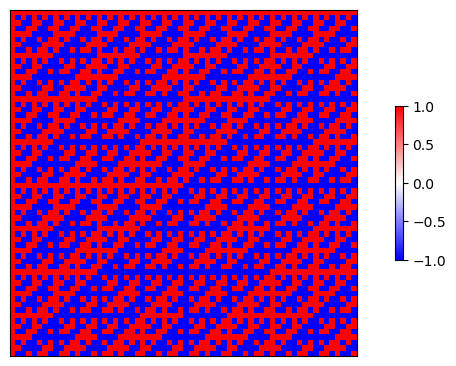

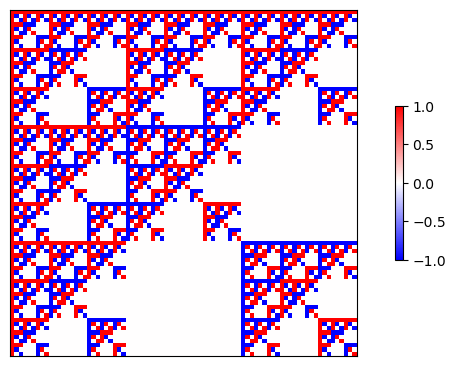

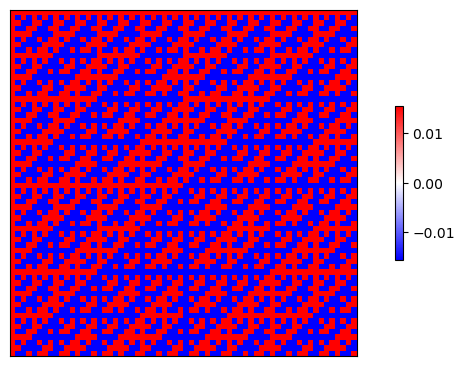

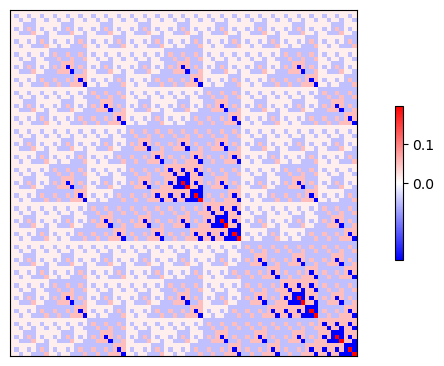

In [11]:
#######################################################################
## Figure 2a,b ##
#######################################################################

#Plot H matrices
plot_H_matrix('matrix_s2_l6.pdf', 6, num_states = 2, invert = False, size = 8)
plot_H_matrix('matrix_s3_l4.pdf', 4, num_states = 3, invert = False, size = 8)

#######################################################################
## Figure 2c,d ##
#######################################################################

#Plot inverse of H matrices
plot_H_matrix('matrix_s2_l6_inv.pdf', 6, num_states = 2, invert = True, size = 8)
plot_H_matrix('matrix_s3_l4_inv.pdf', 4, num_states = 3, invert = True, size = 8)

In [4]:
#######################################################################
## Computational resource analyses ##
#######################################################################

result_dict = {
    's' : [],
    'l' : [],
    'time' : [],
    'memory': [],
    'method': [],
    'n_coef': []}
for s in range(2, 11):
    print(s)
    max_l = int(np.floor(np.log(4000)/np.log(s)))
    for l in range(1, max_l+1):
        #Recursive inverse numerically
        comp_reca = H_matrix_recursive_resources(invert_lib = 'scipy', l_start = l, l_end = l, num_states = s, invert = True, invert_numerically = True)
        result_dict['s'] += [s]
        result_dict['l'] += [l]
        result_dict['time'] += list(comp_reca['time']['mean'])
        result_dict['memory'] += list(comp_reca['memory']['mean'])
        result_dict['method'] += ['reca']
        result_dict['n_coef'] += [np.power(s, l)]
        #Recursive inverse
        comp_reci = H_matrix_recursive_resources(invert_lib = 'scipy', l_start = l, l_end = l, num_states = s, invert = True)
        result_dict['s'] += [s]
        result_dict['l'] += [l]
        result_dict['time'] += list(comp_reci['time']['mean'])
        result_dict['memory'] += list(comp_reci['memory']['mean'])
        result_dict['method'] += ['reci']
        result_dict['n_coef'] += [np.power(s, l)]
        #Coefficients inverse
        comp_geli = H_matrix_elements_resources(l_start = l, l_end = l, num_states = s, invert = True)
        result_dict['s'] += [s]
        result_dict['l'] += [l]
        result_dict['time'] += list(comp_geli['time']['mean'])
        result_dict['memory'] += list(comp_geli['memory']['mean'])
        result_dict['method'] += ['geli']
        result_dict['n_coef'] += [np.power(s, l)]
        #Coefficients inverse (10 coefficients)
        comp_geli10 = H_matrix_elements_resources(l_start = l, l_end = l, num_states = s, invert = True, n_elements = 10)
        result_dict['s'] += [s]
        result_dict['l'] += [l]
        result_dict['time'] += list(comp_geli10['time']['mean'])
        result_dict['memory'] += list(comp_geli10['memory']['mean'])
        result_dict['method'] += ['geli10']
        result_dict['n_coef'] += [np.power(s, l)]
#Save
result_df = pd.DataFrame(result_dict)
result_df.to_csv("performance_df_scipy.txt", index = False)


2
3
4
5
6
7
8
9
10


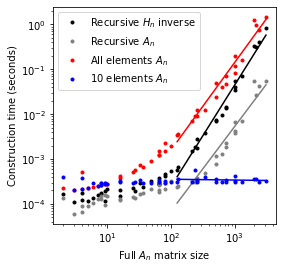

In [5]:
#######################################################################
## Figure 2e ##
#######################################################################

#Plot time consumption
plot_df = copy.deepcopy(result_df)
plot_df.sort_values('n_coef')
plot_df_dict = {
    'Recursive $H_{n}$ inverse': plot_df.loc[plot_df['method']=='reca',:],
    'Recursive $A_{n}$': plot_df.loc[plot_df['method']=='reci',:],
    'All elements $A_{n}$': plot_df.loc[plot_df['method']=='geli',:],
    '10 elements $A_{n}$': plot_df.loc[plot_df['method']=='geli10',:],
}
color_dict = {
    'Recursive $H_{n}$ inverse': 'black',
    'Recursive $A_{n}$': 'grey',
    'All elements $A_{n}$': 'red',
    '10 elements $A_{n}$': 'blue',
}
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
#Plot
for i in plot_df_dict.keys():
    plt.plot(plot_df_dict[i]['n_coef'], plot_df_dict[i]['time'], '.', label = i, 
             color = color_dict[i])
    x = np.log10(plot_df_dict[i].loc[plot_df_dict[i]['n_coef']>100,'n_coef'])
    y = np.log10(plot_df_dict[i].loc[plot_df_dict[i]['n_coef']>100,'time'])
    coef = np.polyfit(x, y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.plot(10**np.asarray([min(x), max(x)]), 10**poly1d_fn(np.asarray([min(x), max(x)])), '-', color = color_dict[i]) #'--k'=black dashed line

# plt.xticks(range(1, max_l+1, 1))
plt.xlabel("Full $A_n$ matrix size")
plt.ylabel("Construction time (seconds)")
# plt.title("Construction time")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.savefig("performance_time_new_scipy.pdf", format="pdf", bbox_inches="tight")
plt.show()

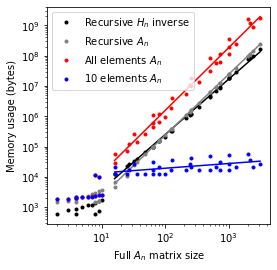

In [6]:
#######################################################################
## Figure 2f ##
#######################################################################

#Plot memory consumption
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
#Plot
for i in plot_df_dict.keys():
    plt.plot(plot_df_dict[i]['n_coef'], plot_df_dict[i]['memory'], '.', label = i,
             color = color_dict[i])
    x = np.log10(plot_df_dict[i].loc[plot_df_dict[i]['n_coef']>10,'n_coef'])
    y = np.log10(plot_df_dict[i].loc[plot_df_dict[i]['n_coef']>10,'memory'])
    coef = np.polyfit(x, y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
#     if i=="Recursive $H_{n}$ inverse":
    plt.plot(10**np.asarray([min(x), max(x)]), 10**poly1d_fn(np.asarray([min(x), max(x)])), '-', color = color_dict[i]) #'--k'=black dashed line
#     else:
#         plt.plot(10**np.asarray([min(x), max(x)]), 10**poly1d_fn(np.asarray([min(x), max(x)])), ':', color = color_dict[i]) #'--k'=black dashed line

# plt.xticks(range(1, max_l+1, 1))
plt.xlabel("Full $A_n$ matrix size")
plt.ylabel("Memory usage (bytes)")
# plt.title("Construction time")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.savefig("performance_memory_new_scipy.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
#######################################################################
## Linear model of memory usage for numerical inverse ##
#######################################################################

result_df = pd.read_csv("performance_df_scipy.txt")
plot_df = copy.deepcopy(result_df)
result_df_sub = plot_df.loc[plot_df['method']=='reca',:]
x = np.log10(result_df_sub.loc[result_df_sub['n_coef']>10,'n_coef'])
y = np.log10(result_df_sub.loc[result_df_sub['n_coef']>10,'memory'])
coef = np.polyfit(x, y,1)

print("All genotypes in DNA string (s = 4) of length 10 (n = 10)")
print("Memory usage for An")
print((10**(coef[0]*np.log10((4**10)**2)+coef[1]))/np.power(1024,5)) #500 million PB (largest mem machine = 160 TB)
x = list(product(range(4), repeat=10))
print("Number of epistatic coefficients of order 1-3")
print(len([i for i in x if len([j for j in i if j!=0])==1]))
print(len([i for i in x if len([j for j in i if j!=0])==2]))
print(len([i for i in x if len([j for j in i if j!=0])==3]))

print("All genotypes in AA string (s = 20) of length 4 (n = 4)")
print("Memory usage for An")
print((10**(coef[0]*np.log10((20**4)**2)+coef[1]))/np.power(1024,5)) #500 thousand PB (largest mem machine = 160 TB)
x = list(product(range(20), repeat=4))
print("Number of epistatic coefficients of order 1-3")
print(len([i for i in x if len([j for j in i if j!=0])==1]))
print(len([i for i in x if len([j for j in i if j!=0])==2]))
print(len([i for i in x if len([j for j in i if j!=0])==3]))

#######################################################################
## Linear model of memory usage for get elements ##
#######################################################################

result_df = pd.read_csv("performance_df_scipy.txt")
plot_df = copy.deepcopy(result_df)
result_df_sub = plot_df.loc[plot_df['method']=='geli',:]
x = np.log10(result_df_sub.loc[result_df_sub['n_coef']>10,'n_coef'])
y = np.log10(result_df_sub.loc[result_df_sub['n_coef']>10,'memory'])
coef = np.polyfit(x, y,1)

print("Memory usage for get elements (GB)")
print((10**(coef[0]*np.log10(30+405+3240)+coef[1]))/np.power(1024,3)) #2.5 GB
print((10**(coef[0]*np.log10(76+2166+27436)+coef[1]))/np.power(1024,3)) #192 GB

#Linear model of time usage for get elements
result_df = pd.read_csv("performance_df_scipy.txt")
plot_df = copy.deepcopy(result_df)
result_df_sub = plot_df.loc[plot_df['method']=='geli',:]
x = np.log10(result_df_sub.loc[result_df_sub['n_coef']>100,'n_coef'])
y = np.log10(result_df_sub.loc[result_df_sub['n_coef']>100,'time'])
coef = np.polyfit(x, y,1)

print("Time usage for get elements (seconds)")
print((10**(coef[0]*np.log10(30+405+3240)+coef[1]))) #1 second
print((10**(coef[0]*np.log10(76+2166+27436)+coef[1]))) #99 seconds

All genotypes in DNA string (s = 4) of length 10 (n = 10)
Memory usage for An
511282346.9697795
Number of epistatic coefficients of order 1-3
30
405
3240
All genotypes in AA string (s = 20) of length 4 (n = 4)
Memory usage for An
527222.4756532153
Number of epistatic coefficients of order 1-3
76
2166
27436
Memory usage for get elements (GB)
2.5319726493263954
192.03816718046303
Time usage for get elements (seconds)
1.7752997208935037
103.8739304661889


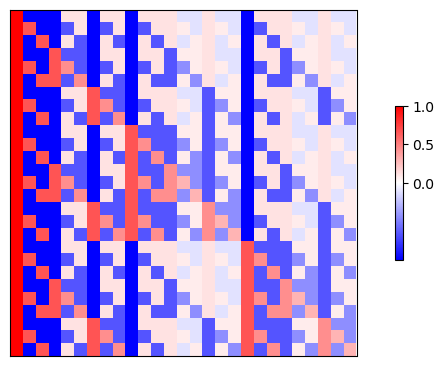

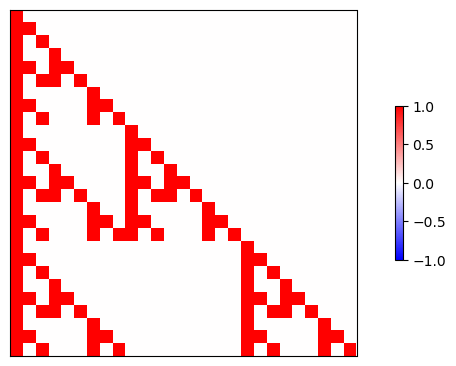

In [13]:
#######################################################################
## Figure 3d ##
#######################################################################

plot_VH_matrix('matrix_s3_l3_vh_inv.pdf', 3, num_states = 3, invert = True, size = 8)
plot_G_matrix('matrix_s3_l3_g_inv.pdf', 3, num_states = 3, invert = True, size = 8)